In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model
from PIL import Image
import torchmetrics
import os
from tqdm import tqdm
import cv2

In [2]:
palette_coco_stuff=[[0, 192, 64], [0, 192, 64], [0, 64, 96], [128, 192, 192],
                 [0, 64, 64], [0, 192, 224], [0, 192, 192], [128, 192, 64],
                 [0, 192, 96], [128, 192, 64], [128, 32, 192], [0, 0, 224],
                 [0, 0, 64], [0, 160, 192], [128, 0, 96], [128, 0, 192],
                 [0, 32, 192], [128, 128, 224], [0, 0, 192], [128, 160, 192],
                 [128, 128, 0], [128, 0, 32], [128, 32, 0], [128, 0, 128],
                 [64, 128, 32], [0, 160, 0], [0, 0, 0], [192, 128, 160],
                 [0, 32, 0], [0, 128, 128], [64, 128, 160], [128, 160, 0],
                 [0, 128, 0], [192, 128, 32], [128, 96, 128], [0, 0, 128],
                 [64, 0, 32], [0, 224, 128], [128, 0, 0], [192, 0, 160],
                 [0, 96, 128], [128, 128, 128], [64, 0, 160], [128, 224, 128],
                 [128, 128, 64], [192, 0, 32], [128, 96, 0], [128, 0, 192],
                 [0, 128, 32], [64, 224, 0], [0, 0, 64], [128, 128, 160],
                 [64, 96, 0], [0, 128, 192], [0, 128, 160], [192, 224, 0],
                 [0, 128, 64], [128, 128, 32], [192, 32, 128], [0, 64, 192],
                 [0, 0, 32], [64, 160, 128], [128, 64, 64], [128, 0, 160],
                 [64, 32, 128], [128, 192, 192], [0, 0, 160], [192, 160, 128],
                 [128, 192, 0], [128, 0, 96], [192, 32, 0], [128, 64, 128],
                 [64, 128, 96], [64, 160, 0], [0, 64, 0], [192, 128, 224],
                 [64, 32, 0], [0, 192, 128], [64, 128, 224], [192, 160, 0],
                 [0, 192, 0], [192, 128, 96], [192, 96, 128], [0, 64, 128],
                 [64, 0, 96], [64, 224, 128], [128, 64, 0], [192, 0, 224],
                 [64, 96, 128], [128, 192, 128], [64, 0, 224], [192, 224, 128],
                 [128, 192, 64], [192, 0, 96], [192, 96, 0], [128, 64, 192],
                 [0, 128, 96], [0, 224, 0], [64, 64, 64], [128, 128, 224],
                 [0, 96, 0], [64, 192, 192], [0, 128, 224], [128, 224, 0],
                 [64, 192, 64], [128, 128, 96], [128, 32, 128], [64, 0, 192],
                 [0, 64, 96], [0, 160, 128], [192, 0, 64], [128, 64, 224],
                 [0, 32, 128], [192, 128, 192], [0, 64, 224], [128, 160, 128],
                 [192, 128, 0], [128, 64, 32], [128, 32, 64], [192, 0, 128],
                 [64, 192, 32], [0, 160, 64], [64, 0, 0], [192, 192, 160],
                 [0, 32, 64], [64, 128, 128], [64, 192, 160], [128, 160, 64],
                 [64, 128, 0], [192, 192, 32], [128, 96, 192], [64, 0, 128],
                 [64, 64, 32], [0, 224, 192], [192, 0, 0], [192, 64, 160],
                 [0, 96, 192], [192, 128, 128], [64, 64, 160], [128, 224, 192],
                 [192, 128, 64], [192, 64, 32], [128, 96, 64], [192, 0, 192],
                 [0, 192, 32], [64, 224, 64], [64, 0, 64], [128, 192, 160],
                 [64, 96, 64], [64, 128, 192], [0, 192, 160], [192, 224, 64],
                 [64, 128, 64], [128, 192, 32], [192, 32, 192], [64, 64, 192],
                 [0, 64, 32], [64, 160, 192], [192, 64, 64], [128, 64, 160],
                 [64, 32, 192], [192, 192, 192], [0, 64, 160], [192, 160, 192],
                 [192, 192, 0], [128, 64, 96], [192, 32, 64], [192, 64, 128],
                 [64, 192, 96], [64, 160, 64], [64, 64, 0]]
classes_coco_stuff = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
            'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
            'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
            'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
            'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
            'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
            'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
            'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
            'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
            'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
            'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
            'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
            'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner',
            'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet',
            'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile',
            'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain',
            'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble',
            'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower',
            'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel',
            'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal',
            'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net',
            'paper', 'pavement', 'pillow', 'plant-other', 'plastic',
            'platform', 'playingfield', 'railing', 'railroad', 'river', 'road',
            'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf',
            'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs',
            'stone', 'straw', 'structural-other', 'table', 'tent',
            'textile-other', 'towel', 'tree', 'vegetable', 'wall-brick',
            'wall-concrete', 'wall-other', 'wall-panel', 'wall-stone',
            'wall-tile', 'wall-wood', 'water-other', 'waterdrops',
            'window-blind', 'window-other', 'wood']

config_coco_stuff = '/mnt/disk2/arda_efe/graduation/ITACLIP/configs/cfg_coco_stuff164k.py'

In [3]:
model = init_model(config_coco_stuff, device='cuda')
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)

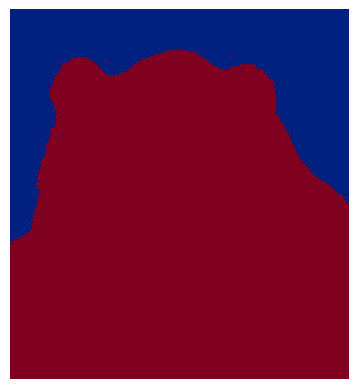

In [7]:
IMG_PATH = 'demo.jpg'
result = inference_model(model, IMG_PATH)
pred_map = result.pred_sem_seg.data.cpu().numpy().squeeze().astype(np.uint8)
pred_map_painted = np.array(palette_coco_stuff)[pred_map].astype(np.uint8)
plt.axis('off')
plt.imshow(pred_map_painted)
plt.show()